# Exp7. Potrait - Semantic Segmentation using DeepLab
1. 배경이 있는 셀카 촬영 (배경과 사람의 거리가 멀면 좋다)
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체와 배경 분리
3. 배경 블러 처리
4. 피사체를 배경의 원래 위치에 합성

### 세그멘테이션 (Segmentation)
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션이라고 한다. 모든 픽셀에 라벨을 할당하고 같은 라벨은 공통적인 특징을 가진다고 가정한다.  
세그멘테이션 중에서도 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 **시맨틱 세그멘테이션**이라고 한다.  
더 나아가서 **인스턴스 세그멘테이션**은 사람 개개인별로 다른 라벨을 갖게 해 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하는 것이 목표다.  
세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용되는데 그 중에 **DeepLab 알고리즘**은 성능이 매우 좋아 최근까지도 많이 이용된다. 

In [1]:
import os
# 웹에서 이미지 다운로드할 때 사용
import urllib
# OpenCV로 이미지 처리
import cv2
import numpy as np
# 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 1. 내 사진 인물모드

(2208, 1242, 3)


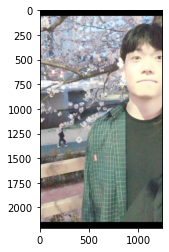

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# PixelLib에서 제공해주는 모델 다운로드

# 저장할 파일 이름 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f2bc0acacd0>)

In [4]:
# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

PASCAL VOC 데이터로 학습된 모델을 이용한다. 모델마다 학습시킨 데이터에 따라 결과가 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요하다.

In [6]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

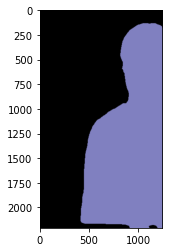

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있다. segvalues에는 class_ids와 masks가 있다.  
이제 물체마다 output에 어떤 색상으로 나타나 있는지 알아내보자. 

In [10]:
# 아래 코드를 이해하지 않아도 좋다
# PixelLib에서 그대로 가져온 코드
# 주목해야 할 것은 생상 코드 결과물이다!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15]

array([192, 128, 128])

In [12]:
# output 이미지가 BGR 순서대로 채널 배치가 되어 있기 때문에 추출해야 하는 색상 값은 순서를 아래처럼 바꿔야 한다.
seg_color = (128, 128, 192)

(2208, 1242)


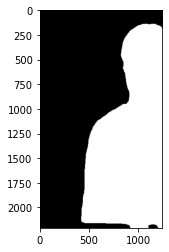

In [13]:
# seg_color로만 이루어진 마스크 생성

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

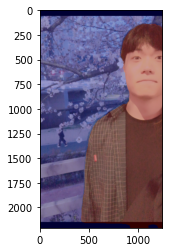

In [14]:
# 원래 이미지와 겹쳐서 보기
img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

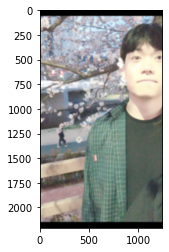

In [15]:
# blur() 함수로 배경 흐리게 만들기

# (13, 13)은 blurring kernel size
img_orig_blur = cv2.blur(img_orig, (13, 13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

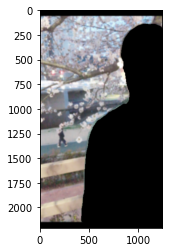

In [16]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전된다. 반전된 세그멘테이션 결과를 이용해 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 

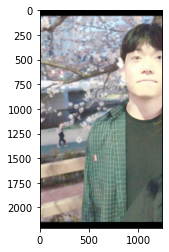

In [17]:
# 배경 영상과 사람 영상 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 사진에서 문제점 찾기
음... 비교적 배경과 인물의 경계가 명확한 사진이어서 그런지 blur되지 않아야 하는 부분이 blur된다던가 하는 문제는 없었다.  
사실 귀에 꽂은 벚꽃이 내심 배경으로 처리되지 않고 인물로 처리되지 않을까 생각했지만 세그멘테이션이 잘 수행된 것 같다.
굳이 문제점을 꼽자면 정수리에 머리카락들이 섬세하게 세그멘테이션되지 않은 부분이 있는데, 노드에서 언급했듯 세그멘테이션 모듈의 한계인 것 같다.

## 2. 고양이 아웃포커싱

(1858, 1398, 3)


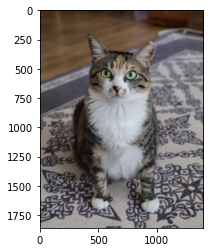

In [18]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
segvalues, output = model.segmentAsPascalvoc(img_path)

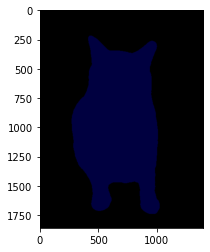

In [20]:
plt.imshow(output)
plt.show()

In [21]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [22]:
colormap[8]  # 고양이의 output 색상

array([64,  0,  0])

In [23]:
# output 이미지가 BGR 순서대로 채널 배치가 되어 있기 때문에 추출해야 하는 색상 값은 순서를 아래처럼 바꿔야 한다.
seg_color = (0, 0, 64)

(1858, 1398)


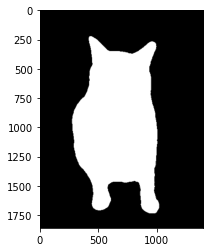

In [24]:
# seg_color로만 이루어진 마스크 생성

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

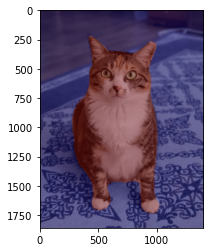

In [25]:
# 원래 이미지와 겹쳐서 보기
img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

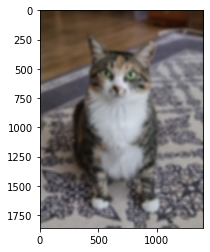

In [26]:
# blur() 함수로 배경 흐리게 만들기

# (30, 30)은 blurring kernel size
img_orig_blur = cv2.blur(img_orig, (30, 30)) # 더 강한 blur 처리
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

고양이 이미지 원본이 이미 아웃포커싱이 약간 되어 있어서 보다 강한 blur처리를 위해 kernel size를 (30, 30)으로 주었다.

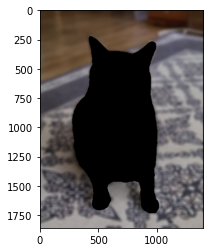

In [27]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

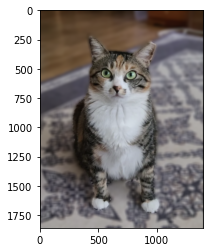

In [28]:
# 배경 영상과 사람 영상 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 사진에서 문제점 찾기
고양이 사진 또한 내가 고른 사진이 난해하지 않아서인지 무리없이 세그멘테이션이 잘 이루어졌다. 문제점을 찾기 위해 보다 복잡한 이미지를 가져왔어야 했나 하는 생각이 든다.  
다른 조원들의 경우에는 피사체와 배경이 제대로 분리되지 않는다던가, 고양이 귀가 잘린다던가 하는 문제가 있는 것으로 아는데, 내 경우에는 생각보다 DeepLab 알고리즘의 성능이 좋은지 특별한 문제점은 찾지 못했다.

## 3. 배경 크로마키 처리

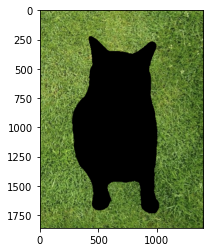

In [29]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/grass.png'  
bg_orig = cv2.imread(bg_path)

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_concat = cv2.bitwise_and(bg_orig, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_concat, cv2.COLOR_BGR2RGB))
plt.show()

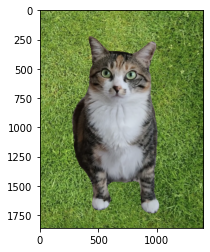

In [30]:
# 배경 영상과 사람 영상 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_concat)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 사진에서 문제점 찾기
배경으로 grass 이미지를 가져온 뒤, bitwise 연산으로 고양이 mask만큼 잘라내 뒤, 두 이미지를 합쳤다. 
앞에서 고양이 사진의 배경을 blur처리 했을 때는 큰 문제가 없어 보였는데, 배경을 다른 이미지로 합성해보니 고양이 앞발의 미세한 그림자까지 고양이로 인식해 세그멘테이션 된 것을 알 수 있었다. 아마 원본 배경에서는 카펫의 색상과 유사해 눈에 띄지 않았던 것 같다. 근데 사실 고양이의 그림자까지 가져오는게 (그림자까지 고양이의 일부로 보는 것이) 문제점인지 여부는 세그멘테이션을 수행하는 사람의 의도에 따라 다르지 않나싶다. 

## 4. 해결방안 및 회고
보다 섬세하고 정확한 이미지 세그멘테이션을 위해서는 영상 속 RGB 입력으로부터 깊이를 예측하는 struct2depth처럼, 시맨틱 세그멘테이션 단계에서 피사체와 배경의 깊이 정보까지 가지고 세그멘테이션을 수행하는 방법이 있을 것 같다. 단순히 배경인 카펫과 시맨틱 세그멘테이션의 라벨인 고양이로 분리하기보다 피사체의 깊이 정보까지 고려해 세그멘테이션을 한다면 정확도가 올라가지 않을까 싶다.  
이번 노드를 통해서 구글밋이나 ZOOM의 영상 배경 blur처리나 배경 합성이 어떤 식으로 이루어질 수 있는지(물론 이미지가 아니라 real-time 영상이지만) 어렴풋이나마 이해하게 되었다. 영상은 이미지의 나열이니까 비슷하지 않을까 하는 생각이 들긴 하는데, 더 찾아보고 알아보아야 할 것 같다. 